# Ejercicio 12: Multimodal Embeddings

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

In [43]:
!pip install umap-learn

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import normalize
import umap
from sentence_transformers import SentenceTransformer, util

%matplotlib inline

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Paso 1

In [44]:
PATH_FOTOS = '/kaggle/input/images/*.jpg' 
img_paths = sorted(glob.glob(PATH_FOTOS))

model = SentenceTransformer('clip-ViT-B-32')

if not img_paths:
    print(" No se encontraron imágenes. Verifica la ruta.")
else:
    images = [Image.open(p).convert('RGB') for p in img_paths]
    texts = ["a bed", "a bicycle", "a car", "a cat", "a dog", "a person"]
    print(f"Cargadas {len(images)} imágenes y {len(texts)} textos.")

Cargadas 18 imágenes y 6 textos.


In [45]:
# Obtener embeddings
img_emb_raw = model.encode(images, convert_to_numpy=True)
txt_emb_raw = model.encode(texts, convert_to_numpy=True)

# Normalizar primero (L2)
img_emb_norm = normalize(img_emb_raw, norm='l2')
txt_emb_norm = normalize(txt_emb_raw, norm='l2')

# Mean Centering
img_mean = np.mean(img_emb_norm, axis=0)
txt_mean = np.mean(txt_emb_norm, axis=0)

# Restamos el centro para mover ambas nubes al origen (0,0)
img_centered = img_emb_norm - img_mean
txt_centered = txt_emb_norm - txt_mean

# Volvemos a normalizar después de centrar
img_final = normalize(img_centered, norm='l2')
txt_final = normalize(txt_centered, norm='l2')

print("Embeddings centrados y normalizados para cerrar el 'Modality Gap'.")

Embeddings centrados y normalizados para cerrar el 'Modality Gap'.


# Paso 2

In [46]:
# Verificación de Dimensiones 
print(f"Forma de los vectores de imagen: {img_embeddings.shape}")
print(f"Forma de los vectores de texto:  {text_embeddings.shape}")

if img_embeddings.shape[1] == text_embeddings.shape[1]:
    print(f"\nAmbos viven en el mismo espacio de {img_embeddings.shape[1]} dimensiones.")
else:
    print("\nLas dimensiones no coinciden, no se pueden comparar.")

Forma de los vectores de imagen: (18, 512)
Forma de los vectores de texto:  (6, 512)

Ambos viven en el mismo espacio de 512 dimensiones.


# Paso 3

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


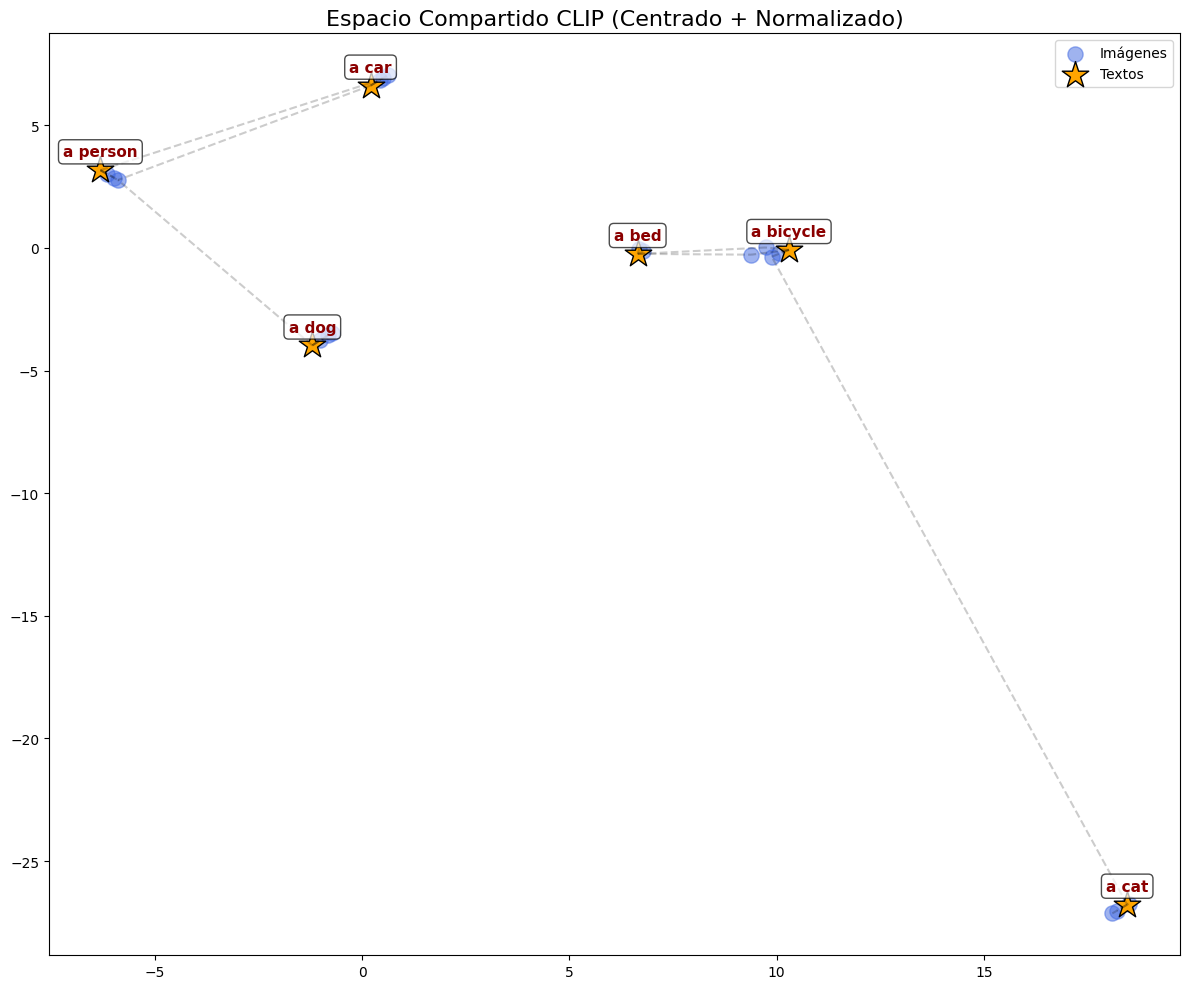

In [47]:
# unir datos
all_embeddings = np.vstack((img_final, txt_final))
n_imgs = len(images)

reducer = umap.UMAP(
    n_neighbors=3,      
    min_dist=0.01,      
    metric='cosine',    
    random_state=99,    
    n_components=2
)

projected_2d = reducer.fit_transform(all_embeddings)

plt.figure(figsize=(12, 10))

# Círculos
plt.scatter(projected_2d[:n_imgs, 0], projected_2d[:n_imgs, 1], 
            c='royalblue', label='Imágenes', alpha=0.5, s=120)

# Estrellas
plt.scatter(projected_2d[n_imgs:, 0], projected_2d[n_imgs:, 1], 
            c='orange', label='Textos', marker='*', s=400, edgecolors='black')

# Etiquetas de texto
for i, txt in enumerate(texts):
    plt.annotate(txt, (projected_2d[n_imgs+i, 0], projected_2d[n_imgs+i, 1]),
                 xytext=(0, 10), textcoords='offset points', 
                 ha='center', fontsize=11, weight='bold', color='darkred',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

# Dibujar líneas de conexión
from sklearn.metrics.pairwise import cosine_similarity


txt_2d = projected_2d[n_imgs:]
img_2d = projected_2d[:n_imgs]

for i in range(len(texts)):
    # Coordenadas del texto actual
    txt_x, txt_y = txt_2d[i]
    
    # Calculamos distancias en el mapa 2D a todas las imágenes
    dists = np.linalg.norm(img_2d - np.array([txt_x, txt_y]), axis=1)
    
    # Tomamos las 4 imágenes más cercanas visualmente
    nearest_3_idx = np.argsort(dists)[:4]
    
    for idx in nearest_3_idx:
        img_x, img_y = img_2d[idx]
        plt.plot([txt_x, img_x], [txt_y, img_y], 'k--', alpha=0.2)

plt.title("Espacio Compartido CLIP (Centrado + Normalizado)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

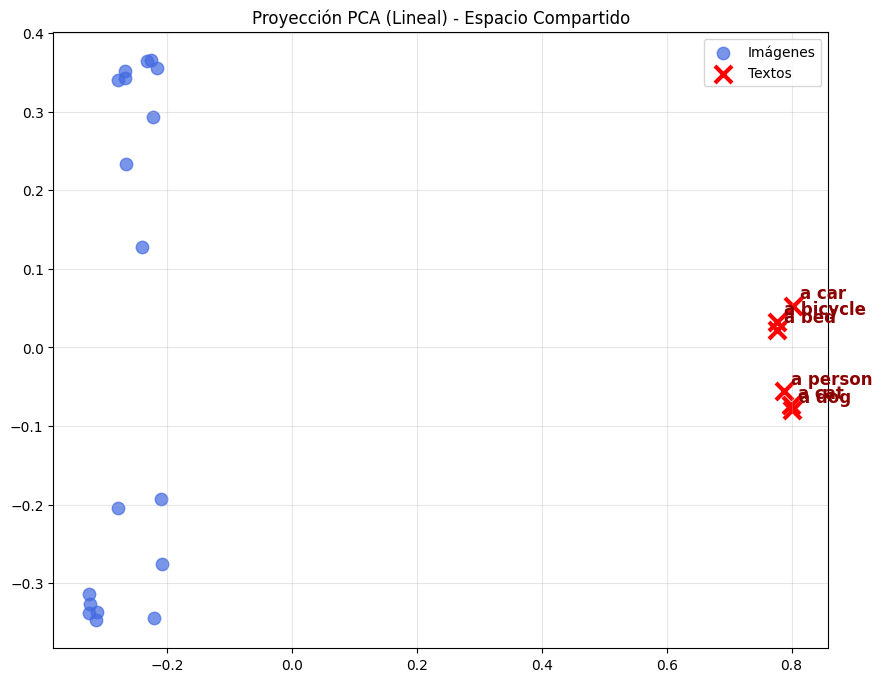

In [51]:
all_embeddings = np.vstack((img_embeddings, text_embeddings))

# Calcular PCA
pca = PCA(n_components=2)
vis_dims = pca.fit_transform(all_embeddings)

# Separar los resultados para poder pintarlos de colores distintos
n_imgs = img_embeddings.shape[0]
img_pca = vis_dims[:n_imgs]
txt_pca = vis_dims[n_imgs:]

# Graficar
plt.figure(figsize=(10, 8))

# Círculos Azules
plt.scatter(img_pca[:, 0], img_pca[:, 1], c='royalblue', label='Imágenes', alpha=0.7, s=80)

# Cruces Rojas
plt.scatter(txt_pca[:, 0], txt_pca[:, 1], c='red', label='Textos', marker='x', s=150, linewidths=3)

# Ponerle nombre a cada cruz roja
for i, txt in enumerate(texts):
    plt.annotate(txt, (txt_pca[i, 0], txt_pca[i, 1]), 
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=12, color='darkred', weight='bold')

plt.title("Proyección PCA (Lineal) - Espacio Compartido")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Paso 4

In [48]:
cos_sim = util.cos_sim(txt_final, img_final)


for i, txt in enumerate(texts):
    # Obtener los índices de las 3 imágenes con mayor score para este texto
    top_3_idx = np.argsort(cos_sim[i].numpy())[-3:][::-1]
    
    print(f"\nTexto: '{txt}'")
    print(f"  Top 3 Imágenes detectadas:")
    for idx in top_3_idx:
        fname = os.path.basename(img_paths[idx])
        score = cos_sim[i][idx]
        
        print(f" {fname} (Similitud: {score:.4f})")


Texto: 'a bed'
  Top 3 Imágenes detectadas:
 bed 1.jpg (Similitud: 0.3894)
 bed 2.jpg (Similitud: 0.3488)
 bed 3.jpg (Similitud: 0.2632)

Texto: 'a bicycle'
  Top 3 Imágenes detectadas:
 bike 1.jpg (Similitud: 0.3427)
 bike 3.jpg (Similitud: 0.3420)
 bike 2.jpg (Similitud: 0.3355)

Texto: 'a car'
  Top 3 Imágenes detectadas:
 car 1.jpg (Similitud: 0.2932)
 car 2.jpg (Similitud: 0.2828)
 car 3.jpg (Similitud: 0.2502)

Texto: 'a cat'
  Top 3 Imágenes detectadas:
 cat 2.jpg (Similitud: 0.3940)
 cat 1.jpg (Similitud: 0.3885)
 cat 3.jpg (Similitud: 0.2798)

Texto: 'a dog'
  Top 3 Imágenes detectadas:
 dog 1.jpg (Similitud: 0.3919)
 dog 2.jpg (Similitud: 0.3787)
 dog 3.jpg (Similitud: 0.3675)

Texto: 'a person'
  Top 3 Imágenes detectadas:
 person 3.jpg (Similitud: 0.1748)
 person 2.jpg (Similitud: 0.1602)
 person 1.jpg (Similitud: 0.1234)


Buscando: 'car'...


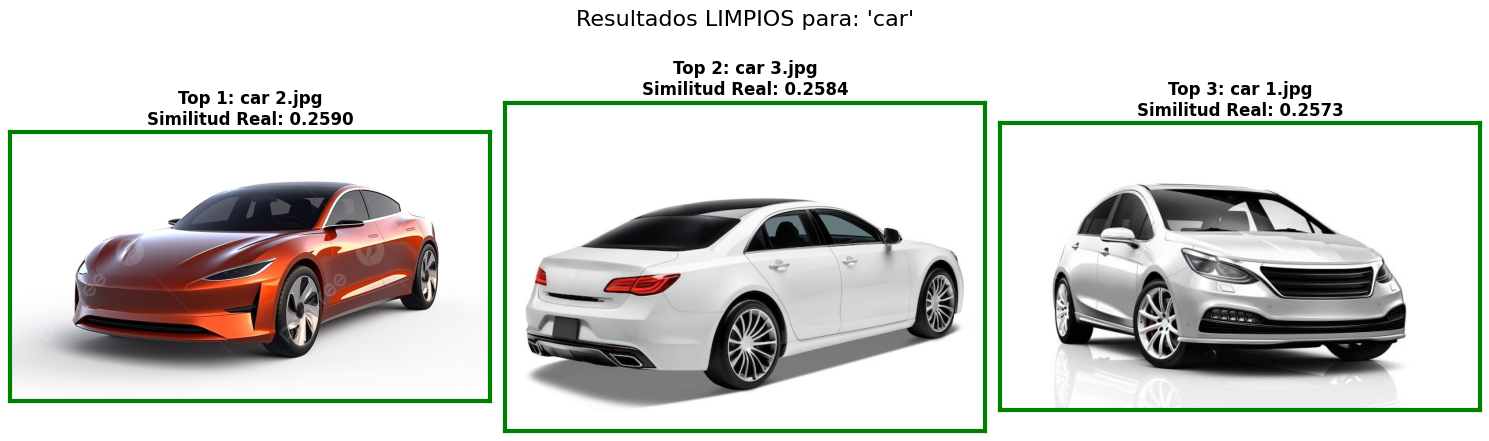

In [52]:
import torch

def buscar_y_mostrar_correcto(texto_query, k=3):
    print(f"Buscando: '{texto_query}'...")
    
    # Generar embedding de la consulta
    query_emb = model.encode([texto_query], convert_to_numpy=True)
    
    # Normalizar la consulta (L2 Norm)
    query_norm = query_emb / np.linalg.norm(query_emb, axis=1, keepdims=True)
    
    # Usar los embeddings
    img_emb_clean = model.encode(images, convert_to_numpy=True)
    img_emb_clean = img_emb_clean / np.linalg.norm(img_emb_clean, axis=1, keepdims=True)
    
    # Calcular similitud (Producto Punto)
    scores = util.cos_sim(query_norm, img_emb_clean)[0]
    
    # Ordenar resultados
    top_results = np.argsort(scores.numpy())[-k:][::-1]
    
    # Mostrar
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_results):
        score = scores[idx]
        img = images[idx]
        name = os.path.basename(img_paths[idx])
        
        # Color del borde: Verde si el score es alto (>0.2), Rojo si es bajo
        color_borde = 'green' if score > 0.2 else 'red'
        
        ax = plt.subplot(1, k, i + 1)
        ax.imshow(img)
        for spine in ax.spines.values():
            spine.set_edgecolor(color_borde)
            spine.set_linewidth(3)
            
        ax.set_title(f"Top {i+1}: {name}\nSimilitud Real: {score:.4f}", fontsize=12, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.suptitle(f"Resultados LIMPIOS para: '{texto_query}'", fontsize=16)
    plt.tight_layout()
    plt.show()


buscar_y_mostrar_correcto("car")